# Imports

In [33]:
# Standard Libraries
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

# MONAI Libraries
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval,Eval_sim

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')


JUPYTER_ALLOW_INSECURE_WRITES=True

In [34]:
import statsmodels.stats.multitest as mt

# Set seeds and configs

In [35]:
# Initialize Configuration
config = {
    'batch_size': 1,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# SimpleITK Configuration
# Set the default number of threads and global behavior for SimpleITK
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



True

# Load the data

In [36]:
imgpath = {}
csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_val_fold0.csv'
csvpath_val_ofd = './Data/splits/test_ofd.csv'
csvpath_test = './Data/splits/simulated.csv'
csvpath_test_lesion = './Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test','test_lesion']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# %%
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test).tail(1)
var_csv['test_lesion'] = pd.read_csv(csvpath_test_lesion)
var_csv['csvpath_val_ofd'] = pd.read_csv(csvpath_val_ofd)
var_csv['csvpath_val_ofd']['seg_path'] =  var_csv['csvpath_val_ofd']['mask_path']
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] =''
    if state !='test':
        var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
        var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state !='test' and state !='test_lesion':
        var_csv[state]['seg_path'] =  var_csv[state]['mask_path']
    if state =='test_lesion':
        var_csv[state]['seg_path'] =  pathBase  + var_csv[state]['seg_path']

print(var_csv['test']['mask_path'])
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval_sim(var_csv['test'],config)
data_test_ofd = Eval(var_csv['csvpath_val_ofd'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
#train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)
ofd_loader = DataLoader(data_test_ofd, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


device = torch.device("cuda")

1    /project/ajoshi_27/akrami/3D_lesion_DF/preproc...
Name: mask_path, dtype: object


# Load the model

In [37]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 2 GPUs!


In [38]:
# specify your model filename
#model_filename = '/scratch1/akrami/models/3Ddiffusion/half/model_epoch984.pt'
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/half/model_epoch549.pt'
# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
       

# Generate an Image

In [39]:
sub_test = next(iter(val_loader))
print(sub_test.keys())
print(sub_test['age'])

dict_keys(['vol', 'peak', 'age', 'ID', 'path', 'mask'])
tensor([46.4300], dtype=torch.float64)


In [40]:

# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2

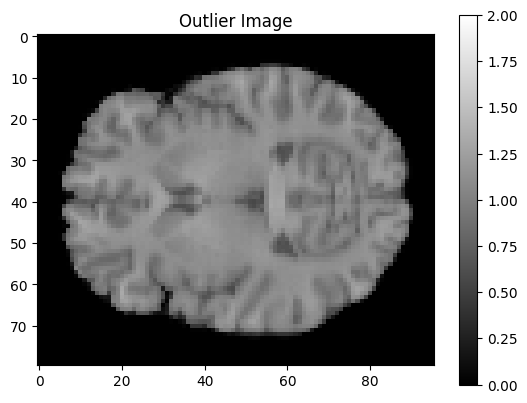

In [41]:
plt.imshow(image_array[0,0][:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Outlier Image')
plt.colorbar()
plt.show()

# Denoise test samples

In [42]:
def denoise(noised_img,sample_time,scheduler,inferer,model):
    with torch.no_grad():
        with autocast(enabled=True):
            for t in range(sample_time - 1, -1, -1):
                batch_size = noised_img.size(0)  # Get the batch size
                t_batch=torch.Tensor((t,)).to(noised_img.device)
                t_batch = t_batch.unsqueeze(0).expand(batch_size, -1)  # Expand tensor `t` to have the desired batch size
                t_batch = t_batch.to(noised_img.device)[:,0] 
                model_output = model(noised_img, timesteps=t_batch)
                noised_img, _ = scheduler.step(model_output, t, noised_img)
            return noised_img

    

In [43]:
def denoise_epistemic(noised_img,sample_time,scheduler,inferer,model):
    max_sample_time= sample_time[-1]
    current_time = sample_time[-2]
    i=-2
    noised_img_org = noised_img.clone()
    with torch.no_grad():
        with autocast(enabled=True):
            for t in range(max_sample_time - 1, -1, -1):
                batch_size = noised_img.size(0)  # Get the batch size
                t_batch=torch.Tensor((t,)).to(noised_img.device)
                t_batch = t_batch.unsqueeze(0).expand(batch_size, -1)  # Expand tensor `t` to have the desired batch size
                t_batch = t_batch.to(noised_img.device)[:,0] 
                model_output = model(noised_img, timesteps=t_batch)
                noised_img, _ = scheduler.step(model_output, t, noised_img)
                if t == current_time:
                    noised_img [i,:,:,:,:]= noised_img_org[i,:,:,:,:]
                    i-=1
                    if i != -6: #TODO hard coded
                        current_time = sample_time[i]
            return noised_img

    

In [44]:
n = 5  # For example, if you want to repeat it 5 times

# Repeat the tensor
repeated_image_array = image_array.repeat(n, 1, 1, 1, 1) 

In [45]:
i = 0
sample_time = 999
noise =torch.randn_like(repeated_image_array)
noisy_img = scheduler.add_noise(original_samples=repeated_image_array, noise=noise, timesteps=torch.tensor(sample_time))
noised_img = noisy_img.to(device)
middle_slice_idx = repeated_image_array.size(-1) // 2

denoised_sample = denoise(noisy_img,sample_time,scheduler,inferer,model)
    




Text(0.5, 1.0, 'std denoised Image')

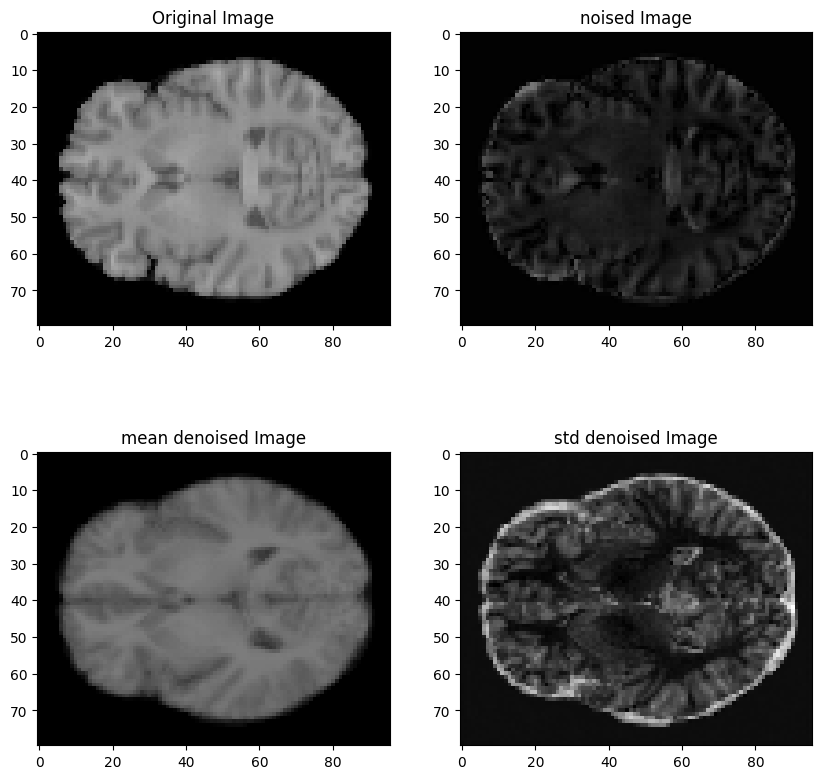

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# Original Image
axes[0, 0].imshow(repeated_image_array[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 0].set_title('Original Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)

# Calculate mean and variance along dimension zero
mean_denoised = torch.mean(denoised_sample[:,0][:,:,:].squeeze(), dim=0).cpu().numpy()
variance_denoised = torch.std(denoised_sample[:,0][:,:,:].squeeze(), dim=0).cpu().numpy()

error = np.abs(repeated_image_array[i][0].squeeze().cpu().numpy()-mean_denoised)

# Original Image
axes[0, 1].imshow(error[:,:,middle_slice_idx].squeeze(), vmin=0, vmax=2, cmap='gray')
axes[0, 1].set_title('noised Image')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)

# Original Image
axes[1, 0].imshow(mean_denoised[:,:,middle_slice_idx].squeeze(), vmin=0, vmax=2, cmap='gray')
axes[1, 0].set_title('mean denoised Image')


# Original Image
axes[1, 1].imshow(variance_denoised[:,:,middle_slice_idx].squeeze(), cmap='gray')
axes[1, 1].set_title('std denoised Image')

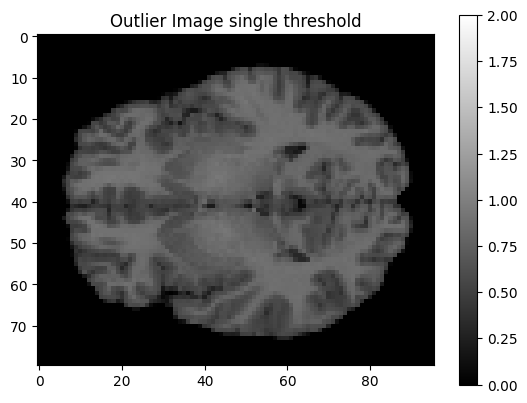

In [47]:
i=0
plt.imshow(denoised_sample[0,0][:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Outlier Image single threshold')
plt.colorbar()
plt.show()



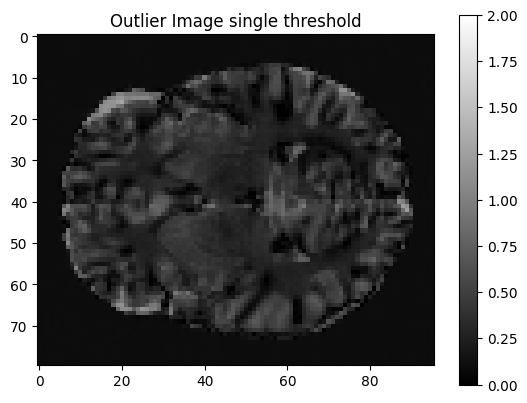

In [48]:
error = np.abs(repeated_image_array[i][0].cpu()-denoised_sample[i][0].cpu())
plt.imshow(error[:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Outlier Image single threshold')
plt.colorbar()
plt.show()


Text(0.5, 1.0, 'q-values')

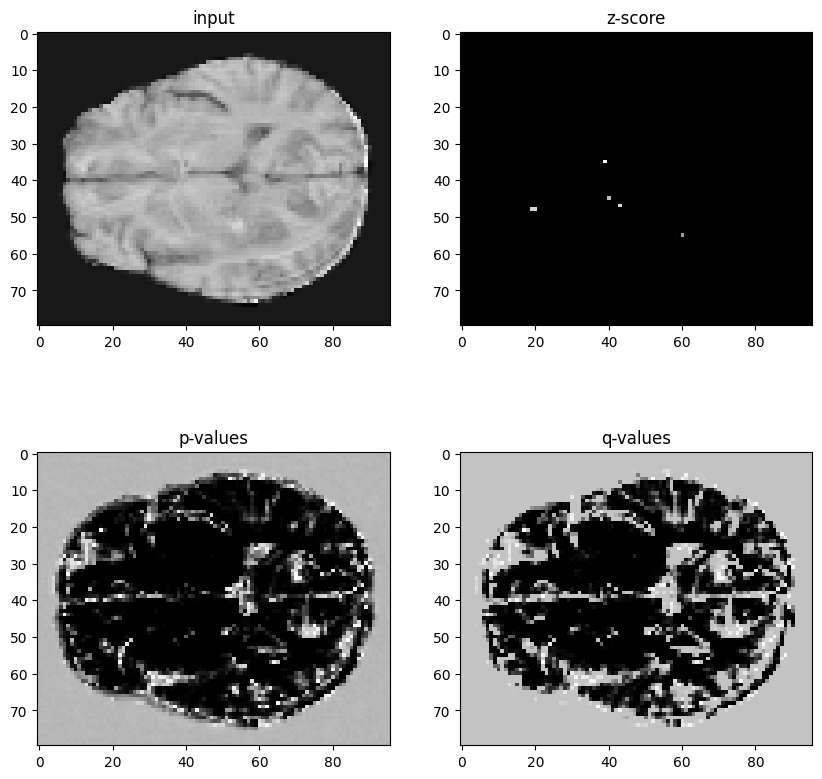

In [34]:

import torch
from scipy.stats import norm
import numpy as np
import statsmodels.stats.multitest as mt

# Sample 3D tensor
x = torch.randn((5, 5, 5))

# Compute z-scores
x =repeated_image_array[0,0,:,:,:].squeeze().cpu().numpy() 
z_scores = (error)/ (variance_denoised+0.000001)

p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# # FDR Correction (Benjamini-Hochberg)
# def fdr_correction(p_values, alpha=0.05):
#     m = p_values.size
#     sorted_indices = np.argsort(p_values)
#     sorted_p_values = p_values[sorted_indices]
#     sorted_q_values = np.zeros(m)
#     prev_bh_value = 0

#     for i, p in enumerate(sorted_p_values):
#         bh_value = (p * m) / (i + 1)
#         sorted_q_values[i] = min(bh_value, prev_bh_value)
#         prev_bh_value = sorted_q_values[i]

#     q_values = np.zeros(m)
#     q_values[sorted_indices] = sorted_q_values

#     return q_values

# q_values = fdr_correction(p_values.flatten())

# # Reshape q-values back to the original tensor shape
# q_values_tensor = torch.tensor(q_values.reshape(x.shape))


p_values_flattened = p_values.flatten()
reject, q_values_corrected, _, _ = mt.multipletests(p_values_flattened, method='fdr_bh')
q_values_tensor_corrected = torch.tensor(q_values_corrected.reshape(x.shape))

fig, axes = plt.subplots(2,2, figsize=(10, 10))
axes[0, 0].imshow(x[:,:,middle_slice_idx].squeeze(),cmap='gray')
axes[0, 0].set_title('input')

axes[0, 1].imshow(z_scores[:,:,middle_slice_idx].squeeze(),cmap='gray')
axes[0, 1].set_title('z-score')
#recon_img = denoise(image_array.to(device),sample_time,scheduler,inferer,model)
# Original Image
axes[1, 0].imshow(p_values[:,:,middle_slice_idx].squeeze(), cmap='gray')
axes[1, 0].set_title('p-values')


axes[1, 1].imshow(q_values_tensor_corrected[:,:,middle_slice_idx].squeeze(), cmap='gray')
axes[1, 1].set_title('q-values')




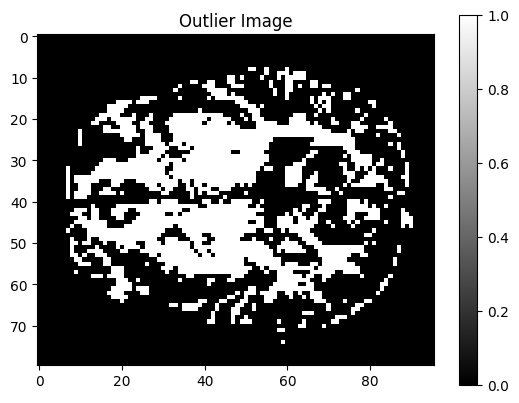

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming p_values is a 3D numpy array containing p-values
alpha = 0.01
outlier_image = np.where(q_values_tensor_corrected< alpha, 1, 0)

# Plotting the middle slice as before
middle_slice_idx = outlier_image.shape[2] // 2
plt.imshow(outlier_image[:,:,middle_slice_idx], cmap='gray')
plt.title('Outlier Image')
plt.colorbar()
plt.show()


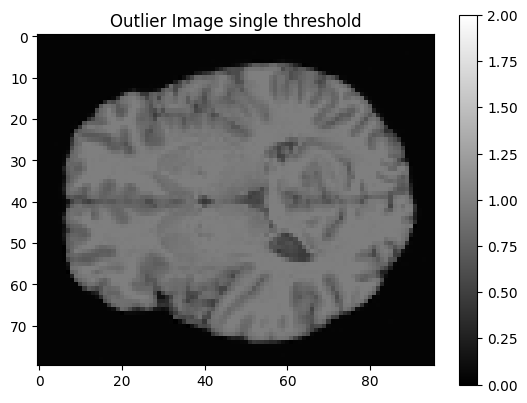

In [47]:
plt.imshow(denoised_sample[0,0][:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Outlier Image single threshold')
plt.colorbar()
plt.show()

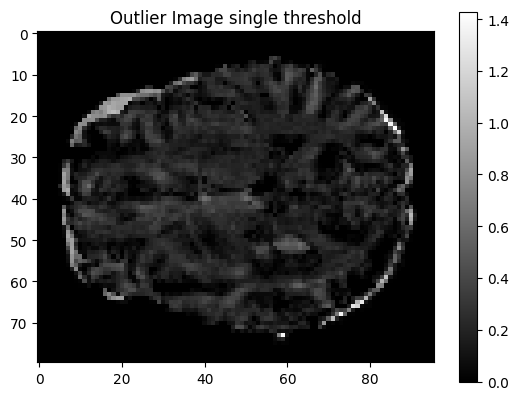

In [48]:
plt.imshow(torch.abs(val_image_inpainted[0,0][:,:,middle_slice_idx]-repeated_image_array[0,0][:,:,middle_slice_idx]).squeeze().cpu().numpy(), cmap='gray')
plt.title('Outlier Image single threshold')
plt.colorbar()
plt.show()

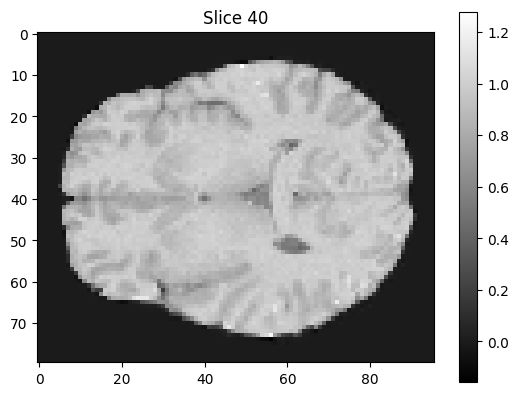

In [49]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


# Save numpy array as .nii image
nii_img = nib.Nifti1Image(val_image_inpainted[0,0].cpu().numpy(), affine=np.eye(4))
nib.save(nii_img, 'sample_image_real_inpaint.nii')



# Load the .nii image
loaded_img = nib.load('sample_image_real_inpaint.nii')
loaded_data = loaded_img.get_fdata()

# Plot a slice from the loaded data
slice_idx = loaded_data.shape[2] // 2
plt.imshow(loaded_data[:, :, slice_idx], cmap='gray')
plt.colorbar()
plt.title(f"Slice {slice_idx}")
plt.show()


In [50]:
# Save numpy array as .nii image
nii_img = nib.Nifti1Image(denoised_sample_500[0,0].cpu().numpy(), affine=np.eye(4))
nib.save(nii_img, 'sample_image_real_500.nii')

In [51]:
# Save numpy array as .nii image
nii_img = nib.Nifti1Image(denoised_sample[0,0].cpu().numpy(), affine=np.eye(4))
nib.save(nii_img, 'sample_image_real_999.nii')

In [52]:
healthy_array = sub_test['path_normal']['data'].to(device)
healthy_array = (healthy_array / peak_expanded)
nii_img = nib.Nifti1Image(healthy_array[0,0].cpu().numpy(), affine=np.eye(4))
nib.save(nii_img, 'sample_image_real_healthy.nii')

KeyError: 'path_normal'

In [ ]:

nii_img = nib.Nifti1Image(repeated_image_array[0,0].cpu().numpy(), affine=np.eye(4))
nib.save(nii_img, 'sample_image_real_lesion.nii')